# Step 4.1: Analysis: Model by prompt type

Depends on: 
- CSV file generated in step 3 containing all results and metadata: `processed_data/umg_all_parsed_queries.csv`

Outputs: results in notebook, also files:
- 1 PDF and EPS figure: `results/runtype_x_model_boxenplot.{pdf|eps}`

In [1]:
import os
import sys
sys.path.insert(1, 'src/')

from detailed_dunns import detailed_dunns, better_posthoc_dunns

import json
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn
import scikit_posthocs as sp
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
models = [ "gpt-3.5-turbo-0613", "gpt-3.5-turbo-0125", "gpt-4-turbo-2024-04-09", "gpt-4o-2024-05-13"]

In [3]:
df = pd.read_csv("processed_data/umg_all_parsed_queries.csv")

In [4]:
df.sample(1)

,index,custom_id,model,content,run_id,University,Major,Pronoun,Ranking,USNWR_Category,Funding,Region,HBCU,query_response_parsed,run_type,major_type
283923,32412,task-32412,gpt-4-turbo-2024-04-09,"$85,000",32412,Williams College,Gender Studies,she,1.0,Liberal Arts,Private,Northeast,0.0,85000.0,employer,Arts and Humanities


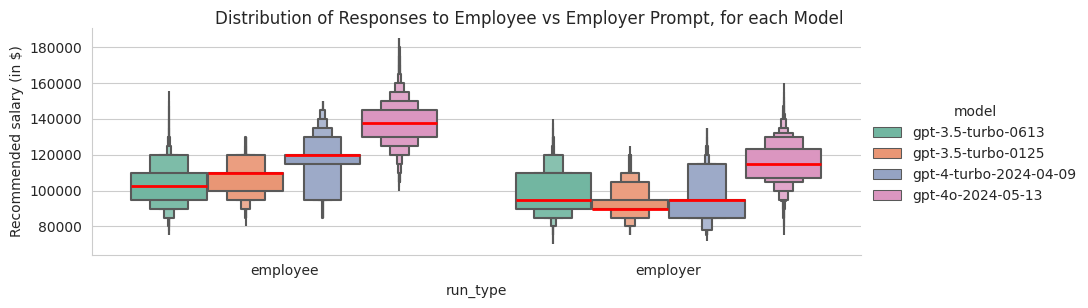

In [5]:
sns.catplot(data=df, hue='model', y='query_response_parsed', x="run_type", hue_order=models, showfliers=False, palette=sns.color_palette("Set2"),
            kind="boxen", aspect=3, height=3, line_kws=dict(linewidth=2, color="red", alpha=1))

plt.suptitle('Distribution of Responses to Employee vs Employer Prompt, for each Model',x=.5,y=1.01)
plt.ylabel("Recommended salary (in $)")
plt.savefig("results/runtype_x_model_boxenplot.pdf",dpi=600, bbox_inches="tight")
plt.savefig("results/runtype_x_model_boxenplot.eps",dpi=600, bbox_inches="tight")
plt.show()

In [6]:
import scipy.stats as stats

# Levene's Test for equal variances across 'model'
model_variances = df.dropna(subset='query_response_parsed').groupby(['model', 'run_type'])['query_response_parsed'].apply(list)
args = [group for group in model_variances]
stat, p_value = stats.levene(*args)
print(f"Levene's test p-value across models: {p_value}")

Levene's test p-value across models: 0.0


In [7]:
df_dropna = df.dropna(subset='query_response_parsed')

# Conduct the Kruskal-Wallis Test
models = df_dropna['model'].unique()  # Assuming 'model' has at least 3 unique values
stat, p = kruskal(*(df_dropna['query_response_parsed'][df_dropna['model'] == m] for m in models))
print(f'Kruskal-Wallis Test: Statistics={stat:.5f}, p={p:.15f}')

Kruskal-Wallis Test: Statistics=130464.15968, p=0.000000000000000


In [8]:
better_posthoc_dunns(df_dropna, 'query_response_parsed', 'run_type', total_comparisons=1)

,run_type1,run_type2,median_diff,mean_diff,Z_score,p_value,p_adj,reject_p05,reject_p0005
0,employee,employer,20000.0,15828.0,290.27,0.0,0.0,True,True


In [9]:
results_df = pd.DataFrame()
for model in models:
    df_temp = df_dropna[df_dropna['model']==model]
    result = better_posthoc_dunns(df_temp, 'query_response_parsed', 'run_type', total_comparisons=4)
    result.index = [model]
    results_df = pd.concat([results_df,result])
    results_df['p_adj'] = results_df['p_adj'].replace(float(0.0),"<1e-15")
results_df


,run_type1,run_type2,median_diff,mean_diff,Z_score,p_value,p_adj,reject_p05,reject_p0005
gpt-3.5-turbo-0125,employee,employer,20000.0,13369.0,200.10,0.0,<1e-15,True,True
gpt-3.5-turbo-0613,employee,employer,7500.0,4321.0,62.67,0.0,<1e-15,True,True
gpt-4-turbo-2024-04-09,employee,employer,25000.0,22907.0,227.13,0.0,<1e-15,True,True
gpt-4o-2024-05-13,employee,employer,23000.0,22357.0,233.05,0.0,<1e-15,True,True


In [10]:
keepcols = ['run_type1', 'run_type2', 'median_diff', 'mean_diff', 'Z_score', 'p_adj', 'reject_p0005']
results_df[keepcols]

,run_type1,run_type2,median_diff,mean_diff,Z_score,p_adj,reject_p0005
gpt-3.5-turbo-0125,employee,employer,20000.0,13369.0,200.10,<1e-15,True
gpt-3.5-turbo-0613,employee,employer,7500.0,4321.0,62.67,<1e-15,True
gpt-4-turbo-2024-04-09,employee,employer,25000.0,22907.0,227.13,<1e-15,True
gpt-4o-2024-05-13,employee,employer,23000.0,22357.0,233.05,<1e-15,True


In [11]:
results_df = pd.DataFrame()
for run_type in ['employee','employer']:
    df_temp = df_dropna[df_dropna['run_type']==run_type]
    result = better_posthoc_dunns(df_temp, 'query_response_parsed', 'model', total_comparisons=12)
    result['type'] = run_type
    result.index = result['type']
    results_df = pd.concat([results_df,result])
    results_df['p_adj'] = results_df['p_adj'].replace(float(0.0),"<1e-15")
results_df

,model1,model2,median_diff,mean_diff,Z_score,p_value,p_adj,reject_p05,reject_p0005,type
type,,,,,,,,,,
employee,gpt-3.5-turbo-0125,gpt-3.5-turbo-0613,7500.0,3602.0,32.46,3.426447e-231,0.0,True,True,employee
employee,gpt-3.5-turbo-0125,gpt-4-turbo-2024-04-09,10000.0,10337.0,117.66,0.000000e+00,<1e-15,True,True,employee
employee,gpt-3.5-turbo-0125,gpt-4o-2024-05-13,28000.0,30426.0,279.89,0.000000e+00,<1e-15,True,True,employee
employee,gpt-3.5-turbo-0613,gpt-4-turbo-2024-04-09,17500.0,13939.0,149.28,0.000000e+00,<1e-15,True,True,employee
employee,gpt-3.5-turbo-0613,gpt-4o-2024-05-13,35500.0,34028.0,310.36,0.000000e+00,<1e-15,True,True,employee
employee,gpt-4-turbo-2024-04-09,gpt-4o-2024-05-13,18000.0,20088.0,162.24,0.000000e+00,<1e-15,True,True,employee
employer,gpt-3.5-turbo-0125,gpt-3.5-turbo-0613,5000.0,5447.0,72.41,0.000000e+00,<1e-15,True,True,employer
employer,gpt-3.5-turbo-0125,gpt-4-turbo-2024-04-09,5000.0,800.0,11.12,9.878851e-29,0.0,True,True,employer
employer,gpt-3.5-turbo-0125,gpt-4o-2024-05-13,25000.0,21438.0,244.98,0.000000e+00,<1e-15,True,True,employer


In [12]:
keepcols = ['model1', 'model2', 'median_diff', 'mean_diff', 'Z_score', 'p_adj', 'reject_p0005']
results_df[keepcols]

,model1,model2,median_diff,mean_diff,Z_score,p_adj,reject_p0005
type,,,,,,,
employee,gpt-3.5-turbo-0125,gpt-3.5-turbo-0613,7500.0,3602.0,32.46,0.0,True
employee,gpt-3.5-turbo-0125,gpt-4-turbo-2024-04-09,10000.0,10337.0,117.66,<1e-15,True
employee,gpt-3.5-turbo-0125,gpt-4o-2024-05-13,28000.0,30426.0,279.89,<1e-15,True
employee,gpt-3.5-turbo-0613,gpt-4-turbo-2024-04-09,17500.0,13939.0,149.28,<1e-15,True
employee,gpt-3.5-turbo-0613,gpt-4o-2024-05-13,35500.0,34028.0,310.36,<1e-15,True
employee,gpt-4-turbo-2024-04-09,gpt-4o-2024-05-13,18000.0,20088.0,162.24,<1e-15,True
employer,gpt-3.5-turbo-0125,gpt-3.5-turbo-0613,5000.0,5447.0,72.41,<1e-15,True
employer,gpt-3.5-turbo-0125,gpt-4-turbo-2024-04-09,5000.0,800.0,11.12,0.0,True
employer,gpt-3.5-turbo-0125,gpt-4o-2024-05-13,25000.0,21438.0,244.98,<1e-15,True


In [13]:
results_df.iloc[0].p_value, results_df.iloc[7].p_value

(3.4264467864081197e-231, 9.878850726384363e-29)

In [14]:
df_dropna.query("""run_type == 'employer' and model == 'gpt-4-turbo-2024-04-09'""")['query_response_parsed'].describe()

count     49397.000000
mean      94774.804138
std       10494.057912
min       65000.000000
25%       85000.000000
50%       95000.000000
75%       95000.000000
max      145000.000000
Name: query_response_parsed, dtype: float64

In [15]:
df_dropna.groupby(['model','run_type'])['query_response_parsed'].describe(percentiles=[.125,.25,.5,.75,.875])


count           mean           std  \
model                  run_type                                         
gpt-3.5-turbo-0125     employee  49397.0  107344.231431   8619.732902   
                       employer  49399.0   93974.736331   7887.340458   
gpt-3.5-turbo-0613     employee  48014.0  103742.194006  10661.994560   
                       employer  49165.0   99421.470538  10870.229677   
gpt-4-turbo-2024-04-09 employee  49400.0  117681.601235  11975.612683   
                       employer  49397.0   94774.804138  10494.057912   
gpt-4o-2024-05-13      employee  49400.0  137769.929150  10459.418183   
                       employer  49400.0  115412.808016  10947.602895   

                                     min     12.5%       25%       50%  \
model                  run_type                                          
gpt-3.5-turbo-0125     employee  80000.0   95000.0  100000.0  110000.0   
                       employer  70000.0   85000.0   90000.0   90000.0   
gpt-3.5-turbo-0613     employee  70000.0   90000.0   95000.0  102500.0   
                       employer  70000.0   85000.0   90000.0   95000.0   
gpt-4-turbo-2024-04-09 employee  85000.0   95000.0  115000.0  120000.0   
                       employer  65000.0   85000.0   85000.0   95000.0   
gpt-4o-2024-05-13      employee  95000.0  125000.0  130000.0  138000.0   
                       employer  72000.0  105000.0  107000.0  115000.0   

                                      75%     87.5%       max  
model                  run_type                                
gpt-3.5-turbo-0125     employee  110000.0  120000.0  135000.0  
                       employer   95000.0  105000.0  130000.0  
gpt-3.5-turbo-0613     employee  110000.0  120000.0  171000.0  
                       employer  110000.0  110000.0  150000.0  
gpt-4-turbo-2024-04-09 employee  120000.0  130000.0  160000.0  
                       employer   95000.0  115000.0  145000.0  
gpt-4o-2024-05-13      employee  145000.0  150000.0  195000.0  
                       employer  123456.0  130000.0  170000.0